<a href="https://colab.research.google.com/github/christopherjneelankavil/malaria_detection_cnn/blob/main/malaria_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
dataset, data_info = tfds.load('malaria', with_info = True, split = ['train'], shuffle_files = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.H7GOW3_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
data_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

In [4]:
for data in iter(dataset[0].take(5)):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [5]:
def splits(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO):

    DATASET_SIZE = len(dataset)

    # train split
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    # test and val split together
    test_val_split = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

    # val dataset split
    val_dataset = test_val_split.take(int(VAL_RATIO * DATASET_SIZE))

    # test dataset split
    test_dataset = test_val_split.skip(int(VAL_RATIO * DATASET_SIZE))

    #return values
    return train_dataset, val_dataset, test_dataset


In [6]:
# test code

TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, TEST_RATIO, VAL_RATIO)

print(
    list(train_dataset.take(1).as_numpy_iterator()),
    list(test_dataset.take(1).as_numpy_iterator()),
    list(val_dataset.take(1).as_numpy_iterator())
)

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), np.int64(1))] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0,

## Data visualization

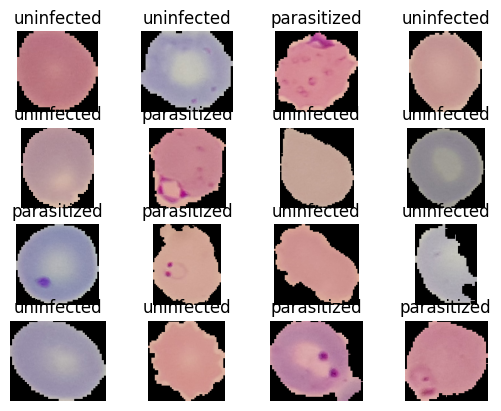

In [7]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    axis = plt.subplot(4,4, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(data_info.features['label'].int2str(label))

## Data preprocessing

In [8]:
IMAGE_SIZE = 224

In [9]:
def resize_and_rescale(image, label):
    return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0, label

In [10]:
train_dataset = train_dataset.map(resize_and_rescale)
val_dataset = val_dataset.map(resize_and_rescale)
test_dataset = test_dataset.map(resize_and_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(f"Image: \n{image}\n\nLabel: {label}")
    print(image.dtype)

Image: 
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

Label: 1
<dtype: 'float32'>


In [12]:
## prefetching

train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

## Model creation

In [ ]:
# LeNet architecture - Sequential

model = tf.keras.Sequential([

    #input layer
    InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),

    #convolutional layers
    Conv2D(filters = 6, kernel_size = 3, activation = 'relu', padding = 'valid', strides= 1),

    # BatchNormalization
    BatchNormalization(),

    #max pooling layer
    MaxPool2D(pool_size = 2, strides = 2),

    # convolutional layers
    Conv2D(filters = 16, kernel_size=3, activation='relu', padding = 'valid', strides = 1),

    # BatchNormalization
    BatchNormalization(),

    # max pooling layer
    MaxPool2D(pool_size = 2, strides = 2),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(100, activation = 'relu'),
    # BatchNormalization
    BatchNormalization(),

    Dense(10, activation = 'relu'),
    # BatchNormalization
    BatchNormalization(),

    # Output
    Dense(1, activation = 'sigmoid')

])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

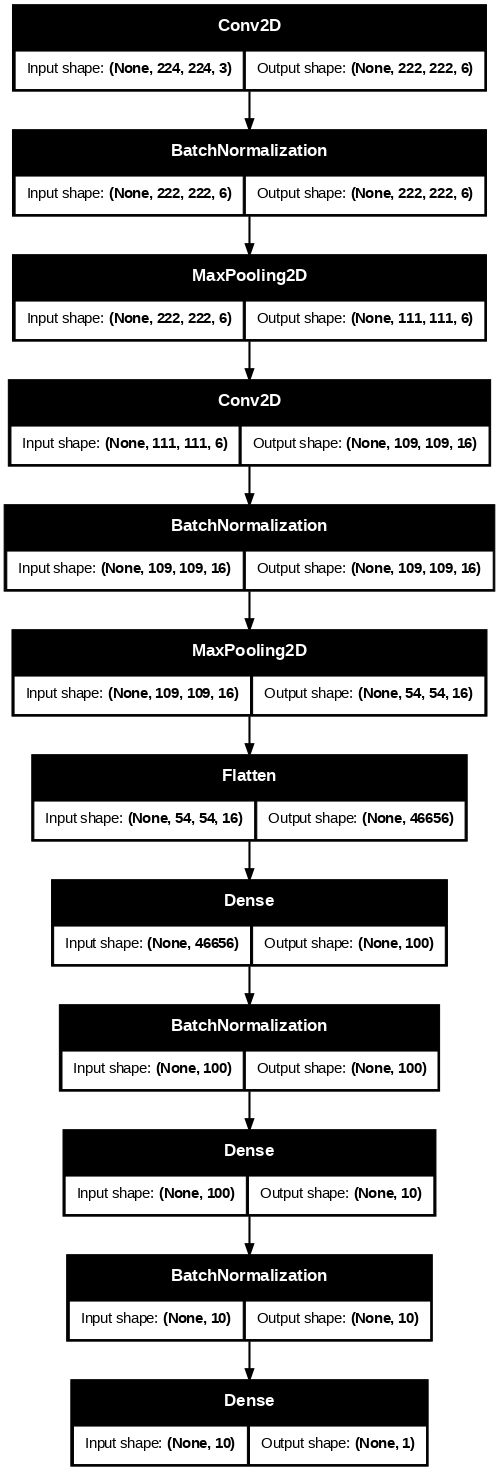

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, dpi = 75)

### Functional API

In [21]:
# Functional API - Lenet Model

from os import name
func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name='Input image')


# Feature extraction
## convolution layers
x = Conv2D(filters=6, kernel_size=3, activation='relu', padding='valid', strides=1)(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='valid', strides=1)(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

#flattened layer
x = Flatten()(x)


# Dense layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)


# Output layers
func_output = Dense(1, activation='sigmoid')(x)

func_model = Model(func_input, func_output, name='Functional_API_model')
func_model.summary()

Model: "Functional_API_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

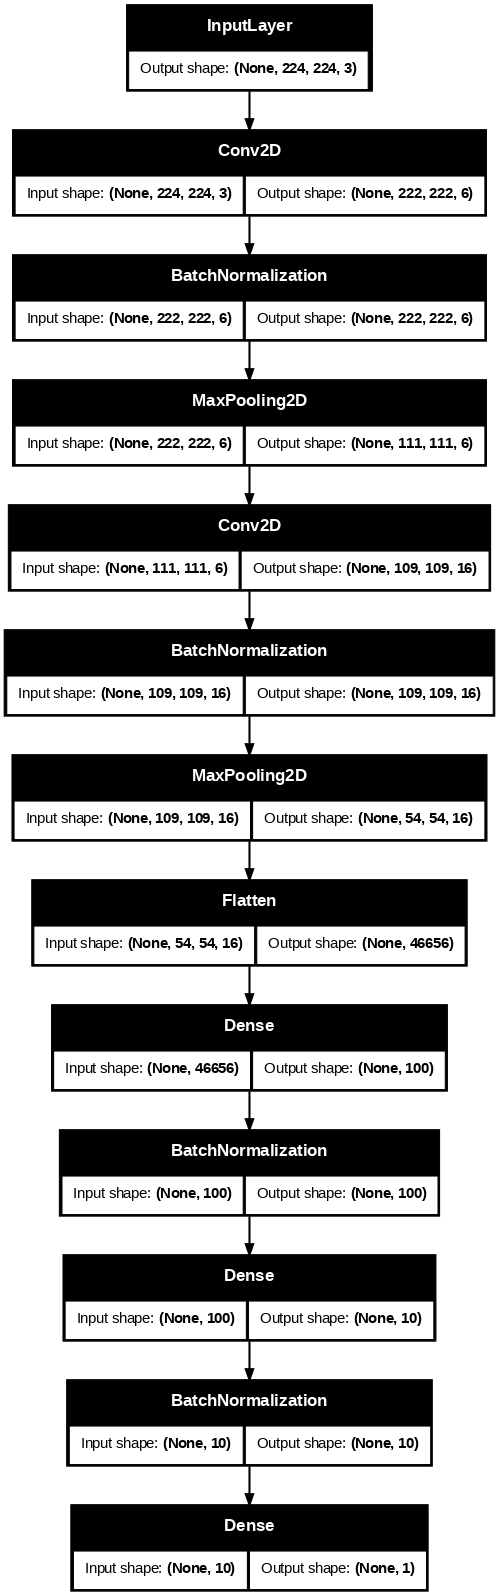

In [22]:
tf.keras.utils.plot_model(func_model, show_shapes=True, dpi=75)

## Model Compiling

In [ ]:
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = BinaryCrossentropy(),
    metrics = ['accuracy']
)

## Model Training

In [ ]:
history = model.fit(
    train_dataset,
    epochs = 10,
    verbose = 1,
    validation_data = val_dataset
)

Epoch 1/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - accuracy: 0.7405 - loss: 0.5071 - val_accuracy: 0.8860 - val_loss: 0.3216
Epoch 2/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.9228 - loss: 0.2124 - val_accuracy: 0.9005 - val_loss: 0.3137
Epoch 3/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - accuracy: 0.9330 - loss: 0.1906 - val_accuracy: 0.9230 - val_loss: 0.2135
Epoch 4/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9454 - loss: 0.1553 - val_accuracy: 0.9350 - val_loss: 0.1883
Epoch 5/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.9513 - loss: 0.1329 - val_accuracy: 0.9343 - val_loss: 0.1908
Epoch 6/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.9577 - loss: 0.1213 - val_accuracy: 0.9249 - val_loss: 0.2257
Epoch 7/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9722 - loss: 0.0755 - val_accuracy: 0.9260 - val_loss: 0.2226
Epoch 8/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.9820 - loss: 0.0528 - 

## Results

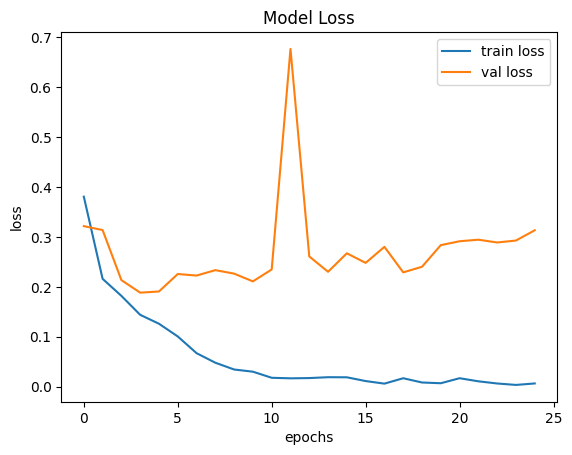

In [ ]:
plt.title("Model Loss")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')

plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

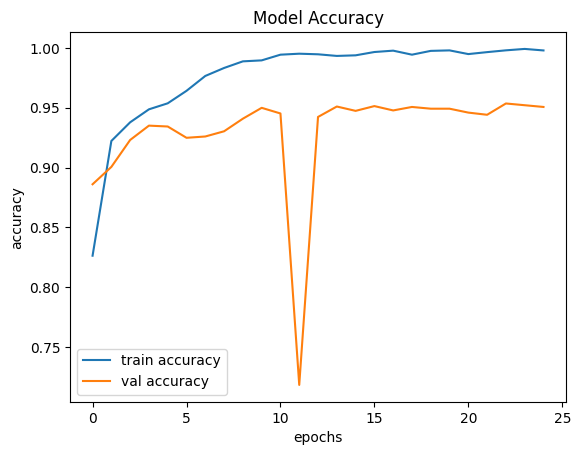

In [ ]:
plt.title("Model Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['train accuracy', 'val accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## Model evaluation and testing

In [ ]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9493 - loss: 0.3317


[0.35912656784057617, 0.9426913261413574]

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Parasite not detected


In [ ]:
def parasite_or_not(value):
    if value < 0.5:
        print("Parasite not detected")
    else:
        print("Parasite detected")

Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
Parasite detected
Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Parasite detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Parasite not detected
Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Parasite detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Parasite not detected
Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Parasite detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Parasite not detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Parasite not detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Parasite not detected


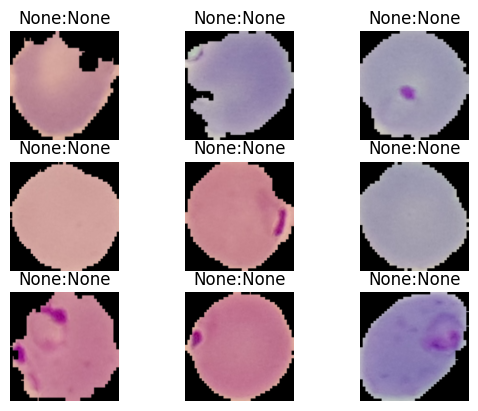

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

    axis = plt.subplot(3,3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,004,365 (53.42 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 9,336,068 (35.61 MB)

## Saving model

In [ ]:
model.save('malaria_detection_model.keras')